<a href="https://colab.research.google.com/github/mshsu/probasets/blob/main/fireballs_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fireballs Demo

The **exponential distribution** can be used to model time between instances of independent, regularly occuring events. Let's look at an example of this in NASA fireballs (meteors and bolides) data. (More info found [here](https://cneos.jpl.nasa.gov/fireballs/). This data is not real time, but very close to it.) Can we model the time between fireballs using the exponential distribution?

## Setup

In [1]:
!pip install symbulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import requests
from symbulate import *
import matplotlib.pyplot as plt

## Data

In [3]:
response = requests.get("https://ssd-api.jpl.nasa.gov/fireball.api?date-min=2014-01-01&req-alt=true")
json_data = response.json()
fireball = pd.DataFrame(json_data['data'])
fireball.columns = json_data['fields']
fireball

,date,energy,impact-e,lat,lat-dir,lon,lon-dir,alt,vel
0,2023-04-26 13:14:59,2.4,0.086,47.0,N,10.7,W,29.6,16.2
1,2023-04-15 08:22:01,309.7,6.3,20.1,S,36.0,E,41.4,17.2
2,2023-04-06 14:47:39,7.2,0.23,57.4,N,109.9,E,31.2,22.1
3,2023-04-01 00:02:03,2.4,0.086,16.8,S,76.0,E,61.8,46.4
4,2023-03-20 06:53:23,2.7,0.095,23.7,S,132.6,E,34.8,None
...,...,...,...,...,...,...,...,...,...
287,2014-03-18 11:02:37,54,1.3,0.0,N,111.8,W,30.5,None
288,2014-02-13 06:47:42,63,1.5,13.3,N,110.7,W,25.0,None
289,2014-01-15 02:46:19,14.0,0.41,18.5,S,141.8,E,29.6,None
290,2014-01-12 16:00:48,7.8,0.24,2.9,N,64.4,E,37.0,16.2


## Wrangling

In [4]:
df_fb = fireball.iloc[:, :]
# Change the datatype of the time variable from string to something called datetime to make it easier to work with
df_fb["datetime"] = pd.to_datetime(df_fb["date"])
# Sort the values by date, with oldest fireball first
df_fb = df_fb[["datetime"]].sort_values(by="datetime", ignore_index=True)

# Find the time since the last fireball for each fireball except for the first one
time_before = [0] + list(pd.to_numeric(df_fb["datetime"]))[:-1]
df_fb["intertime"] = pd.to_numeric(df_fb["datetime"])-pd.Series(time_before)
df_fb["intertime_str"] = df_fb["intertime"].apply(pd.Timedelta)
# Get date and time for each occurrence
df_fb["date"] = df_fb["datetime"].dt.date
df_fb["time"] = df_fb["datetime"].dt.time
# Filter variables down to the ones we want
df_fb=df_fb.iloc[1:][["date", "time", "intertime", "intertime_str"]]

df_fb

,date,time,intertime,intertime_str
1,2014-01-12,16:00:48,341714000000000,3 days 22:55:14
2,2014-01-15,02:46:19,211531000000000,2 days 10:45:31
3,2014-02-13,06:47:42,2520083000000000,29 days 04:01:23
4,2014-03-18,11:02:37,2866495000000000,33 days 04:14:55
5,2014-03-29,13:45:41,960184000000000,11 days 02:43:04
...,...,...,...,...
287,2023-03-20,06:53:23,772315000000000,8 days 22:31:55
288,2023-04-01,00:02:03,1012120000000000,11 days 17:08:40
289,2023-04-06,14:47:39,485136000000000,5 days 14:45:36
290,2023-04-15,08:22:01,754462000000000,8 days 17:34:22


## Rate/Average

In [5]:
beta = df_fb["intertime"].mean()
lambd = 1/(beta/(1000000000*60*60*24))

print('Avg Time btwn Occurrences: %s\nRate: %.4f fireballs per day'
      % (pd.Timedelta(beta), lambd))

Avg Time btwn Occurrences: 11 days 15:59:12.457044673
Rate: 0.0857 fireballs per day


## Exponential Distribution

<ipython-input-6-b252fe28c4a8>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks)


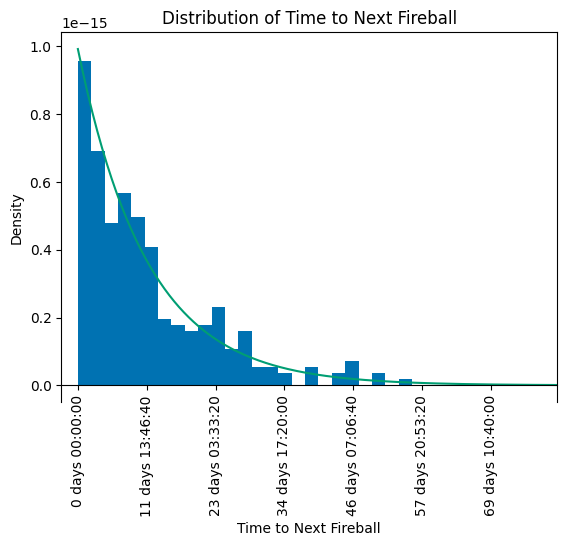

In [6]:
# Plotting the observed data
df_fb["intertime"].hist(density=True, bins=25, grid=False)
# Plotting the theoretical distribution
Exponential(rate=1/beta).plot()

# Cosmetic stuff
ax = plt.gca()
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="Time to Next Fireball")
plt.title(label="Distribution of Time to Next Fireball")
xticks = [str(pd.Timedelta(i)) for i in ax.get_xticks()]
ax.set_xticklabels(xticks)
plt.xticks(rotation=90)
xlims = ax.get_xlim()
plt.show()

## Poisson Distribution

In [7]:
# Get frequency of fireballs by date
df_counts = (df_fb["date"]
             .value_counts()
             .to_frame()
             .reset_index()
             .rename(columns={"index": "date", "date": "freq"})
             .sort_values(by="date", ignore_index=True))

# However, the df_counts we just generated doesn't contain days with 0 fireballs.
# We need to fix this by generating rows for dates with 0 fireballs.
# First, let's find the start and end dates.
start_date = df_counts['date'].min()
end_date = df_counts['date'].max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no fireballs
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2014-01-12,1
1,2014-01-13,0
2,2014-01-14,0
3,2014-01-15,1
4,2014-01-16,0
...,...,...
3386,2023-04-21,0
3387,2023-04-22,0
3388,2023-04-23,0
3389,2023-04-24,0


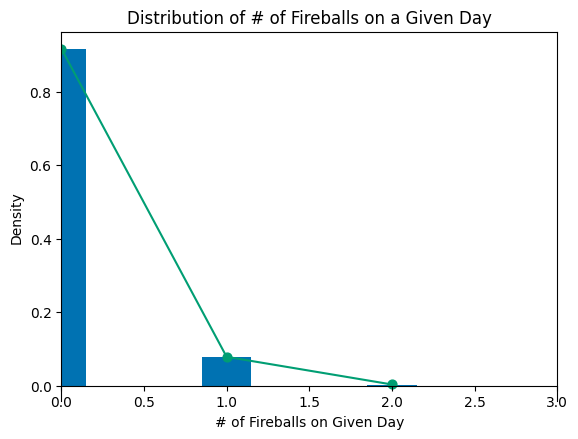

In [8]:
# This makes it so our histogram bar centers line up with the dots on the theoretical distribution
bin_edges=[i+0.5 for i in list(range(min(df_counts["freq"])-1, max(df_counts["freq"])+1, 1))]

# This is the number of days in our timeframe
t=1
# This is our Poisson parameter mu
mu=lambd*t

# Plotting the observed data
df_counts["freq"].hist(density=True, bins=bin_edges, rwidth=0.3, grid=False)
# Plotting the theoretical distribution
Poisson(mu).plot()

# Cosmetic stuff
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="# of Fireballs on Given Day")
plt.title(label="Distribution of # of Fireballs on a Given Day")
plt.xlim((0,max(df_counts["freq"])+1))
plt.show()